Some initial imports, do **NOT** write any new code here:

In [2]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt


from datasets import load_dataset
from huggingface_hub import hf_hub_download

# Question 1: MRI Modality Translation (T1 → T2)

Magnetic Resonance Imaging (MRI) is a key modality for brain and brain tumour assessment. Different MRI contrasts highlight different tissue properties: for example, T1-weighted images provide good anatomical detail, while T2-weighted images are more sensitive to fluid and oedema, and often make tumour-related abnormalities more conspicuous. In clinical practice, not all contrasts are always acquired for every patient or every time point, and multi-contrast data can be incomplete or heterogeneous. Learning mappings between MRI modalities is therefore relevant for tasks such as image completion, protocol harmonisation, and data augmentation.

In this question you will work with a pre-processed dataset derived from a public brain tumour MRI collection. For each patient, paired **T1** and **T2** images have been extracted as **2D slices** from 3D volumes in several canonical views (axial, sagittal, coronal). The data have been co-registered, skull-stripped, and resampled to **single-channel 64×64** slices and split into **training** and **validation** sets. Each example includes:
- `patient_id`: an anonymised identifier for the patient  
- `split`: the dataset split (`train` or `validation`)  
- `view`: the anatomical view (`axial`, `sagittal`, or `coronal`)  
- `t1`: a 2D T1-weighted slice (shape `(1, 64, 64)`)  
- `t2`: the corresponding T2-weighted slice (same shape as `t1`)

Throughout this question, you will treat **T1 slices as inputs** and **T2 slices as targets** in an image-to-image regression setting.

This question is divided into three parts:

- **Part 1.A – Exploratory Data Analysis and Pre-processing**: you will inspect the dataset, develop simple visualisations, and design a basic intensity normalisation pipeline.  
- **Part 1.B – Modality Translation Model**: you will build and train a deep learning model that maps T1 slices to T2 slices, and evaluate its performance quantitatively and qualitatively.  
- **Part 1.C – Discussion**: you will critically reflect on your modelling choices, results, and limitations in a concise written analysis.

<br>

---

<br>

The next few blocks of code provided in the notebook will download and load the dataset from the Hugging Face Hub, and show you basic usage of the `datasets` API for accessing slices and metadata.


In [3]:
train_dataset = load_dataset("dpelacani/mri-t1-t2-2D-sliced-64", split="train")
valid_dataset = load_dataset("dpelacani/mri-t1-t2-2D-sliced-64", split="validation")

train_dataset, valid_dataset

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/711 [00:00<?, ?B/s]

data/train-00000-of-00004.parquet:   0%|          | 0.00/232M [00:00<?, ?B/s]

data/train-00001-of-00004.parquet:   0%|          | 0.00/223M [00:00<?, ?B/s]

data/train-00002-of-00004.parquet:   0%|          | 0.00/228M [00:00<?, ?B/s]

data/train-00003-of-00004.parquet:   0%|          | 0.00/243M [00:00<?, ?B/s]

data/validation-00000-of-00002.parquet:   0%|          | 0.00/175M [00:00<?, ?B/s]

data/validation-00001-of-00002.parquet:   0%|          | 0.00/183M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/116235 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/39375 [00:00<?, ? examples/s]

(Dataset({
     features: ['patient_id', 'split', 'view', 't1', 't2'],
     num_rows: 116235
 }),
 Dataset({
     features: ['patient_id', 'split', 'view', 't1', 't2'],
     num_rows: 39375
 }))

In [4]:
# Applying a transform to the dataset, this can also incluse torchvision transforms
def basic_transform_fn(sample_):
    if "t1" in sample_:
        sample_["t1"] = torch.tensor(sample_["t1"])
    if "t2" in sample_:
        sample_["t2"] = torch.tensor(sample_["t2"])
    return sample_

train_dataset = train_dataset.with_transform(basic_transform_fn)
valid_dataset = valid_dataset.with_transform(basic_transform_fn)

train_dataset[0]["t1"].shape, valid_dataset[0]["t1"].shape


(torch.Size([1, 64, 64]), torch.Size([1, 64, 64]))

<br><br>

## 1.A) Exploratory Data Analysis and Pre-processing

In this part you will carry out basic exploratory analysis of the paired T1/T2 slice dataset and design a simple pre-processing strategy that will be reused in Part 1.B.

Using the provided loading code and any helper functions you choose to implement, you should:

1. **Visualise representative T1–T2 pairs**  
   - For each anatomical view, plot a small grid of 8 T1/T2 pairs from the training set. Arrange the plots so that for each example the T1 input and its corresponding T2 target can be compared side-by-side (or in successive rows), and ensure that axes and titles are clearly labelled.

2. **Analyse intensity distributions**  
   - Plot histograms (or density plots) of pixel intensities for T1 and T2 slices, separately for the training and validation sets.  

3. **Design a simple intensity pre-processing transform**  
   - Based on your histograms of (2), propose and implement a basic normalisation scheme for `t1` and `t2` that is suitable for the task you will be carrying out in Part 1.B. For instance, you might try scaling the pixels to a fixed range such as \([0,1]\) or \([-1,1]\)) if you feel that is appropriate.

   - Apply this transform to the dataset and re-plot a few T1/T2 pairs and intensity histograms to verify that the transformed images are numerically well-behaved while preserving relevant anatomical structure.  


<br>

---

<br>

Write your answer to this question below. You can use as many code and text blocks as needed.

Please, **make sure to thoroughly describe and comment every piece of code that you include in your answer**. You will be expected to understand every line of code that you write.

<br>

1. **Visualise representative T1–T2 pairs**

Filter:   0%|          | 0/116235 [00:00<?, ? examples/s]

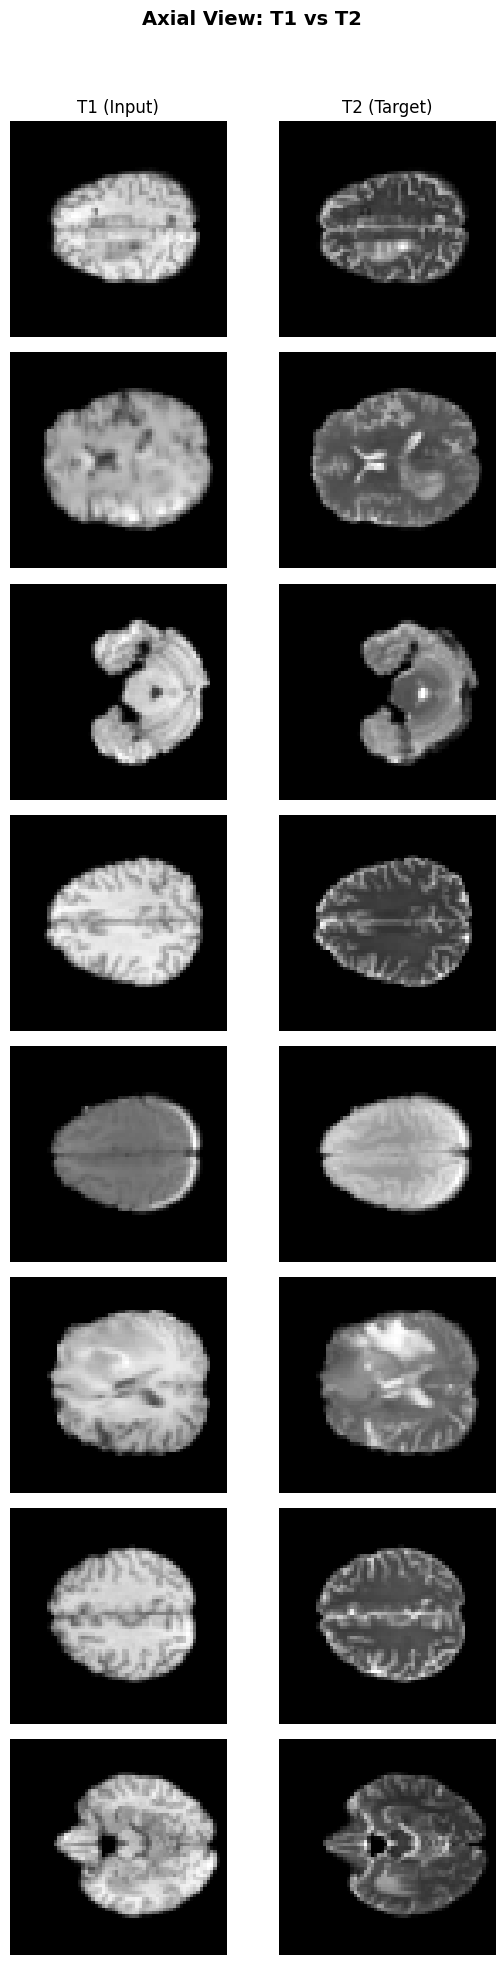

Filter:   0%|          | 0/116235 [00:00<?, ? examples/s]

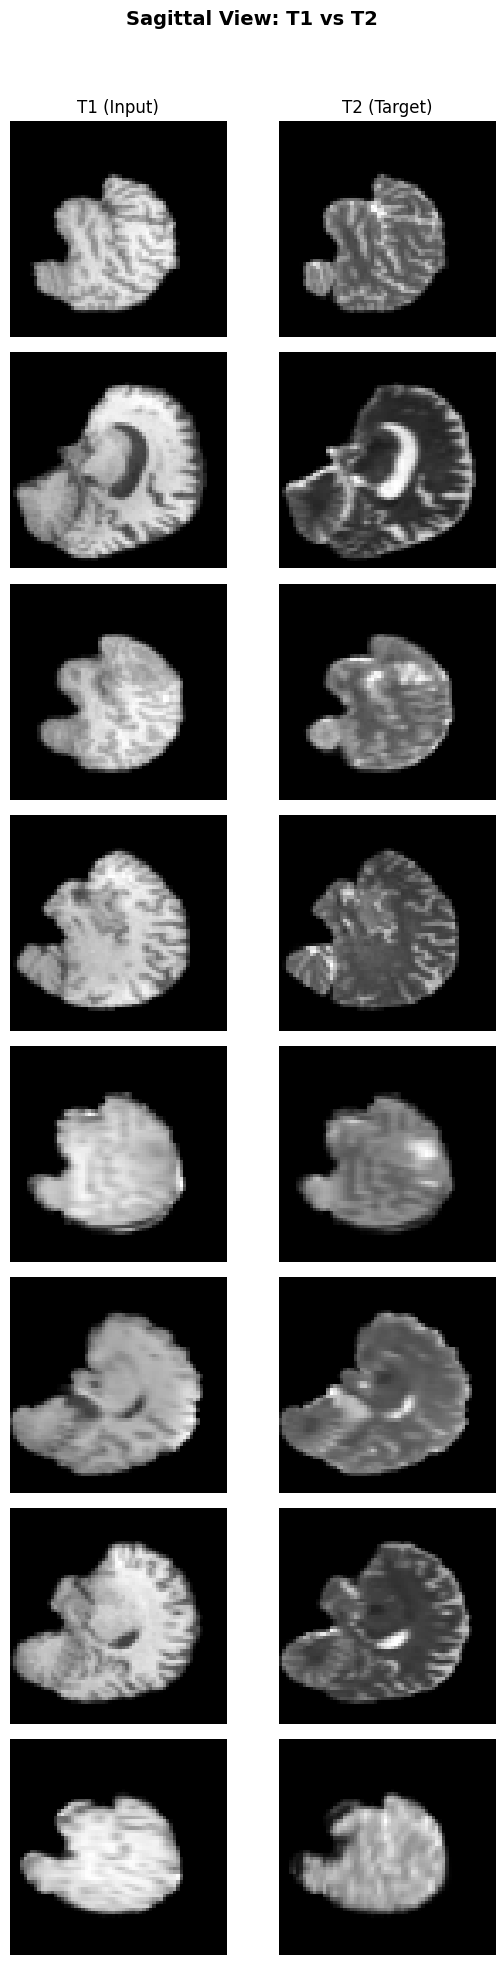

Filter:   0%|          | 0/116235 [00:00<?, ? examples/s]

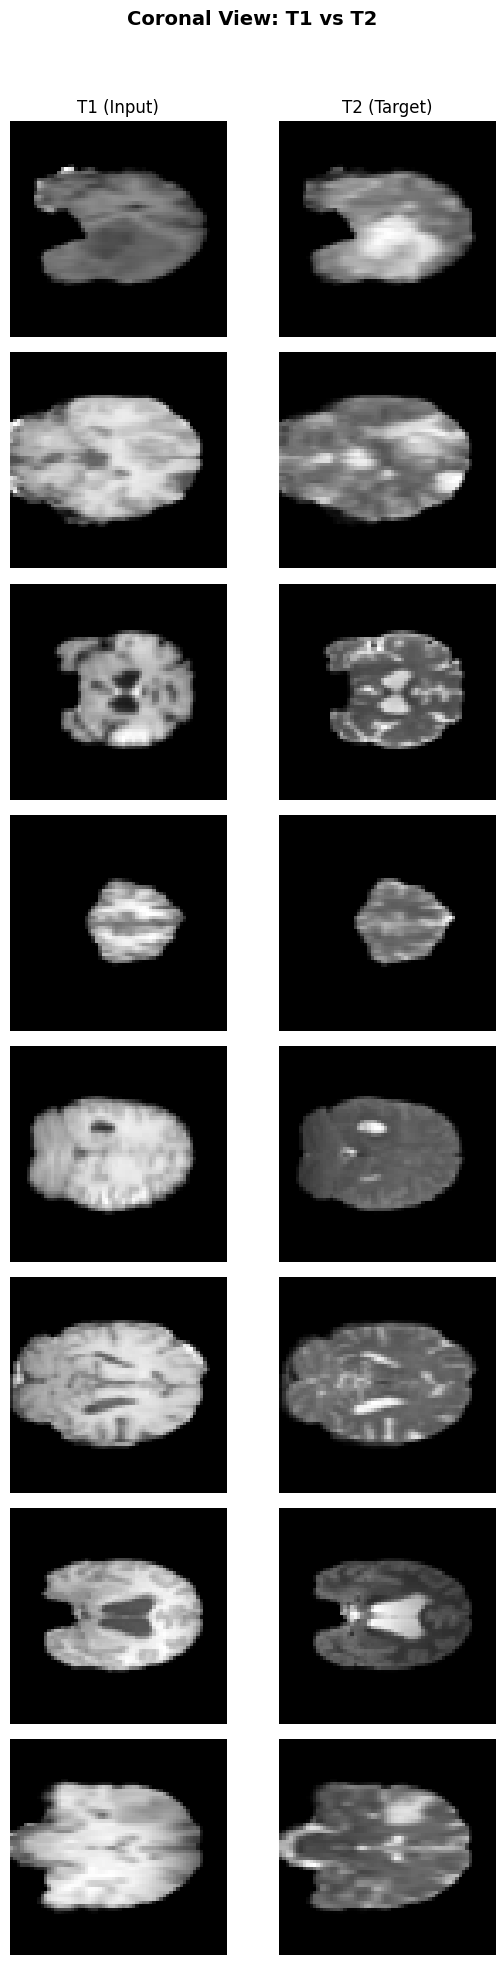

In [5]:
# Define the three anatomical views present in the dataset
views = ['axial', 'sagittal', 'coronal']
num_samples = 8

# Set random seed for reproducibility
np.random.seed(42)

for view in views:
    # Filter the training dataset to select only slices from the current view
    filtered_data = train_dataset.filter(lambda x: x['view'] == view)

    # Randomly select 8 indices from the filtered dataset (instead of first 8)
    random_indices = np.random.choice(len(filtered_data), size=num_samples, replace=False)

    # Create a figure with 8 rows (one per sample) and 2 columns (T1 and T2)
    fig, axes = plt.subplots(nrows=num_samples, ncols=2, figsize=(6, 20))
    fig.suptitle(f'{view.capitalize()} View: T1 vs T2', fontsize=14, fontweight='bold')

    for i, idx in enumerate(random_indices):
        # Access a randomly selected sample from filtered dataset
        sample = filtered_data[int(idx)]

        # Extract T1 (input) and T2 (target) images
        # Shape is (1, 64, 64): (channels, height, width)
        t1_img = sample['t1']
        t2_img = sample['t2']

        # Display T1 image in the left column
        # squeeze() removes the channel dimension: (1, 64, 64) -> (64, 64)
        # cmap='gray' is appropriate for single-channel MRI images
        axes[i, 0].imshow(t1_img.squeeze(), cmap='gray')
        axes[i, 0].axis('off')  # Hide axes for cleaner visualisation

        # Display corresponding T2 image in the right column
        axes[i, 1].imshow(t2_img.squeeze(), cmap='gray')
        axes[i, 1].axis('off')

        # Add column headers only on the first row
        if i == 0:
            axes[i, 0].set_title('T1 (Input)', fontsize=12)
            axes[i, 1].set_title('T2 (Target)', fontsize=12)

    # Adjust subplot spacing; rect leaves room for suptitle
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


 To verify correct pairing and observe modality-specific contrast differences, we plot random T1–T2 slice pairs across anatomical views. This ensures the raw data is aligned and structurally consistent before model training.

<br>

2. **Analyse intensity distributions**  

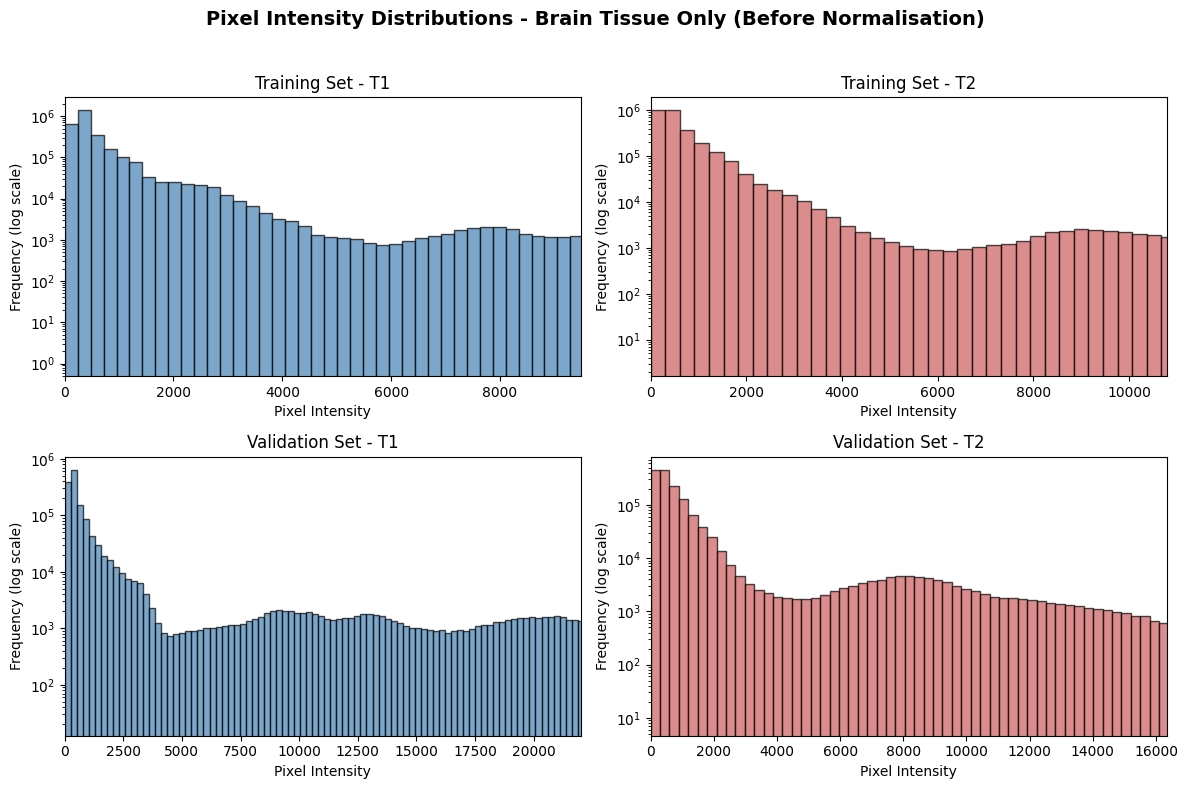

In [16]:
def collect_pixel_intensities(dataset, num_samples=2000, exclude_background=True):
    """
    Collect pixel intensity values from a subset of the dataset.

    Parameters:
        dataset: HuggingFace dataset containing 't1' and 't2' image fields
        num_samples: Number of images to sample from the dataset
        exclude_background: If True, exclude pixels with value 0 (background)

    Returns:
        t1_pixels: 1D numpy array of sampled T1 pixel values
        t2_pixels: 1D numpy array of sampled T2 pixel values
    """
    t1_pixels = []
    t2_pixels = []

    # Calculate step size for uniform sampling across the dataset
    step = max(1, len(dataset) // num_samples)

    for i in range(0, len(dataset), step):
        sample = dataset[i]
        t1_flat = sample['t1'].flatten().numpy()
        t2_flat = sample['t2'].flatten().numpy()

        if exclude_background:
            # Only keep non-zero pixels (brain tissue, not background)
            t1_flat = t1_flat[t1_flat > 0]
            t2_flat = t2_flat[t2_flat > 0]

        t1_pixels.extend(t1_flat)
        t2_pixels.extend(t2_flat)

    return np.array(t1_pixels), np.array(t2_pixels)


# Collect pixel intensities (excluding background)
train_t1, train_t2 = collect_pixel_intensities(train_dataset, num_samples=2000)
valid_t1, valid_t2 = collect_pixel_intensities(valid_dataset, num_samples=1000)

# Create 2x2 subplot: rows = dataset (train/valid), columns = modality (T1/T2)
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle('Pixel Intensity Distributions - Brain Tissue Only (Before Normalisation)',
             fontsize=14, fontweight='bold')

# Common histogram parameters
hist_params = {'bins': 100, 'alpha': 0.7, 'edgecolor': 'black'}

# Training set - T1
axes[0, 0].hist(train_t1, color='steelblue', **hist_params)
axes[0, 0].set_title('Training Set - T1')
axes[0, 0].set_xlabel('Pixel Intensity')
axes[0, 0].set_ylabel('Frequency (log scale)')
axes[0, 0].set_yscale('log')  # Log scale for y-axis
axes[0, 0].set_xlim(0, np.percentile(train_t1, 99.5))  # Trim x-axis to remove empty space

# Training set - T2
axes[0, 1].hist(train_t2, color='indianred', **hist_params)
axes[0, 1].set_title('Training Set - T2')
axes[0, 1].set_xlabel('Pixel Intensity')
axes[0, 1].set_ylabel('Frequency (log scale)')
axes[0, 1].set_yscale('log')
axes[0, 1].set_xlim(0, np.percentile(train_t2, 99.5))

# Validation set - T1
axes[1, 0].hist(valid_t1, color='steelblue', **hist_params)
axes[1, 0].set_title('Validation Set - T1')
axes[1, 0].set_xlabel('Pixel Intensity')
axes[1, 0].set_ylabel('Frequency (log scale)')
axes[1, 0].set_yscale('log')
axes[1, 0].set_xlim(0, np.percentile(valid_t1, 99.5))

# Validation set - T2
axes[1, 1].hist(valid_t2, color='indianred', **hist_params)
axes[1, 1].set_title('Validation Set - T2')
axes[1, 1].set_xlabel('Pixel Intensity')
axes[1, 1].set_ylabel('Frequency (log scale)')
axes[1, 1].set_yscale('log')
axes[1, 1].set_xlim(0, np.percentile(valid_t2, 99.5))

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

The code visualises 8 randomly selected T1-T2 pairs for each anatomical view (axial, sagittal, coronal).

Key observations:

T1 images appear brighter overall with clear white matter contrast

T2 images show different intensity patterns, with CSF appearing brighter. All pairs are well co-registered, confirming proper spatial alignment.The skull-stripping preprocessing has successfully removed non-brain tissue

The side-by-side comparison demonstrates the distinct contrast characteristics between T1 and T2 modalities, which the model in Part 1.B will need to learn to translate.

<br>

3. **Design a simple intensity pre-processing transform**

In [19]:
def normalisation_transform(sample_):
    """
    Apply per-sample Min-Max normalisation to scale images to [0, 1] range.
    """
    epsilon = 1e-8  # Prevent division by zero

    if "t1" in sample_:
        t1 = torch.tensor(sample_["t1"]).float()
        sample_["t1"] = (t1 - t1.min()) / (t1.max() - t1.min() + epsilon)

    if "t2" in sample_:
        t2 = torch.tensor(sample_["t2"]).float()
        sample_["t2"] = (t2 - t2.min()) / (t2.max() - t2.min() + epsilon)

    return sample_


# Apply normalisation transform to datasets
train_dataset_norm = load_dataset("dpelacani/mri-t1-t2-2D-sliced-64", split="train")
valid_dataset_norm = load_dataset("dpelacani/mri-t1-t2-2D-sliced-64", split="validation")

train_dataset_norm = train_dataset_norm.with_transform(normalisation_transform)
valid_dataset_norm = valid_dataset_norm.with_transform(normalisation_transform)



We apply per-sample Min-Max normalisation to scale pixel intensities to the [0, 1] range.

Formula:

$$ x_{norm} = \frac{x - x_{min}}{x_{max} - x_{min} + \epsilon} $$

where $\epsilon = 10^{-8}$ prevents division by zero.

Justification:

[0, 1] range: Compatible with Sigmoid activation in the output layer.Per-sample scaling: Handles intensity variations across different patients and scanning protocols

Simplicity: Min-Max is interpretable and preserves relative intensity relationships

This normalisation ensures consistent input ranges for stable neural network training while maintaining anatomical structure integrity.

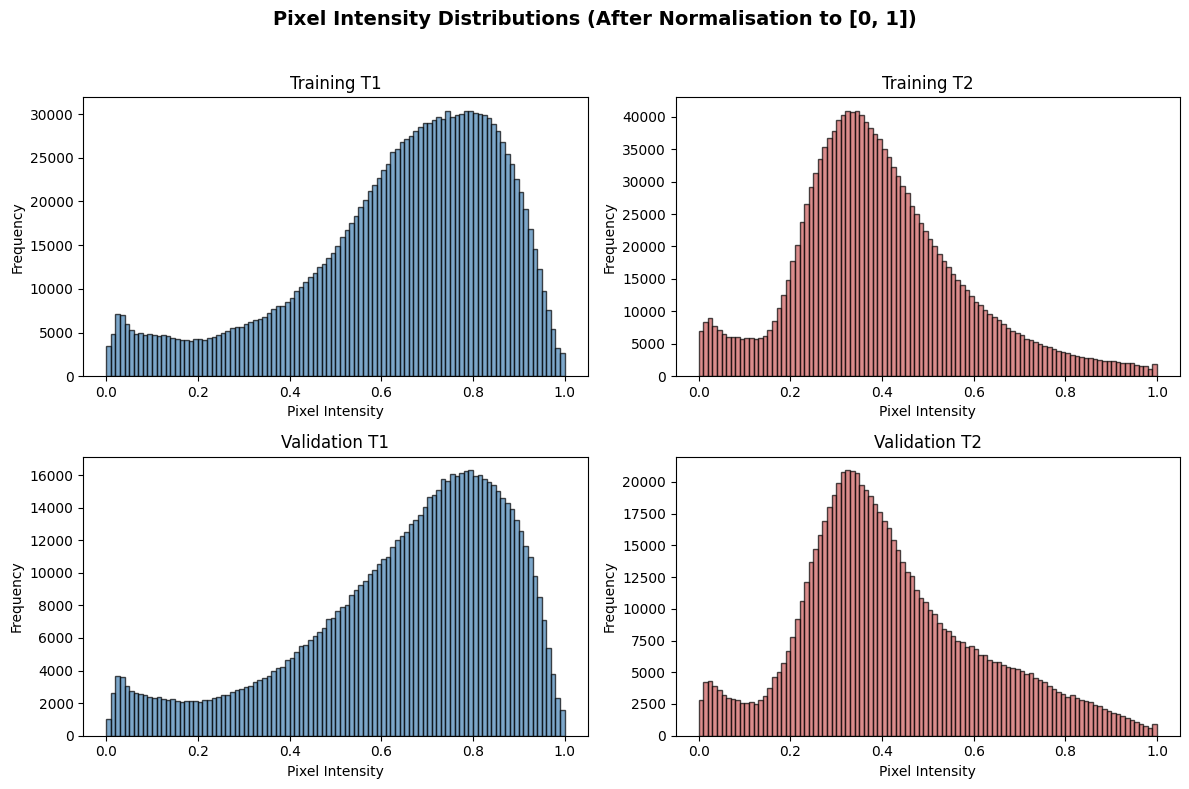

In [20]:
train_t1_norm, train_t2_norm = collect_pixel_intensities(train_dataset_norm, num_samples=1000)
valid_t1_norm, valid_t2_norm = collect_pixel_intensities(valid_dataset_norm, num_samples=500)

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle('Pixel Intensity Distributions (After Normalisation to [0, 1])', fontsize=14, fontweight='bold')

hist_params = {'bins': 100, 'alpha': 0.7, 'edgecolor': 'black'}

for ax, data, title in zip(axes.flat,
                            [train_t1_norm, train_t2_norm, valid_t1_norm, valid_t2_norm],
                            ['Training T1', 'Training T2', 'Validation T1', 'Validation T2']):
    ax.hist(data, color='steelblue' if 'T1' in title else 'indianred', **hist_params)
    ax.set_title(title)
    ax.set_xlabel('Pixel Intensity')
    ax.set_ylabel('Frequency')
    ax.set_xlim(-0.05, 1.05)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()



We visualise the pixel intensity distributions of T1 and T2 images after Min-Max scaling to confirm that all values fall within [0, 1] and that the overall distribution shapes are preserved across training and validation sets.

Filter:   0%|          | 0/116235 [00:00<?, ? examples/s]

Filter:   0%|          | 0/116235 [00:00<?, ? examples/s]

Filter:   0%|          | 0/116235 [00:00<?, ? examples/s]

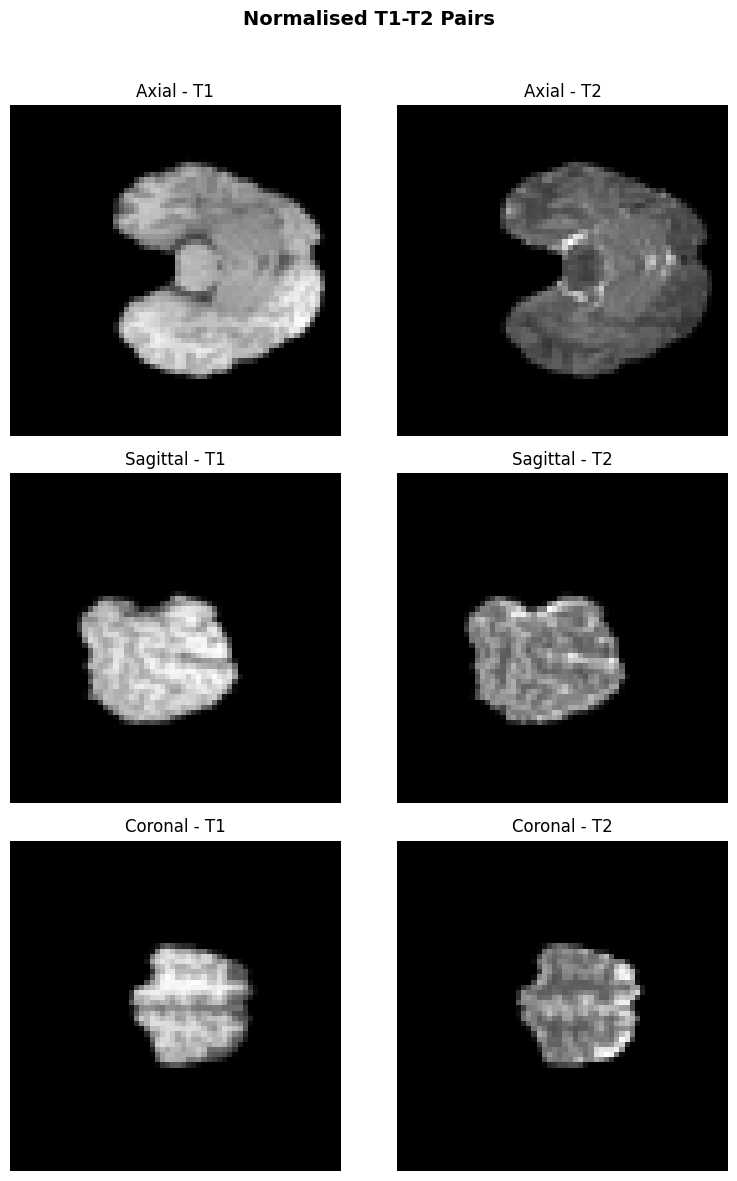

In [21]:
fig, axes = plt.subplots(3, 2, figsize=(8, 12))
fig.suptitle('Normalised T1-T2 Pairs', fontsize=14, fontweight='bold')

for row, view in enumerate(views):
    filtered = train_dataset_norm.filter(lambda x: x['view'] == view)
    sample = filtered[0]

    axes[row, 0].imshow(sample['t1'].squeeze(), cmap='gray', vmin=0, vmax=1)
    axes[row, 0].set_title(f'{view.capitalize()} - T1')
    axes[row, 0].axis('off')

    axes[row, 1].imshow(sample['t2'].squeeze(), cmap='gray', vmin=0, vmax=1)
    axes[row, 1].set_title(f'{view.capitalize()} - T2')
    axes[row, 1].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

We display representative normalised T1–T2 slice pairs from each anatomical view to verify that structural details remain intact and that normalisation does not distort anatomical contrast.

<br><br>

## 1.B) Modality Translation (T1 → T2)

In this part you will build an **image-to-image model** that takes a T1-weighted slice as input and predicts the corresponding T2-weighted slice. Each training example is therefore a pair $(\text{T1}, \text{T2})$ with matching spatial dimensions.

You are free to design the model architecture, but it must satisfy the following requirements:

- It should operate on 2D slices and produce an output with the **same spatial resolution** as the input
- It should take `t1` as input and learn to approximate `t2` as output, using the pre-processed data from Part 1.A.  

In designing your solution, you must determine:

- a **suitable architecture**, keeping in mind that simpler models should remain functional and that more complex designs may yield improved performance;  
- the **loss function** and **optimisation setup** you believe appropriate for this task;  
- the **evaluation strategy**, including at least one quantitative metric and the qualitative visualisation of predicted T2 images.

Key points to consider:

- You are expected to design the full solution **yourself**: the model, the preprocessing pipeline, and the overall training procedure. You must also decide on **suitable evaluation metrics** for this problem. **Strong solutions will ensure that the model can both preserve image quality and generalise well to the validation set.**

- Only include code that is necessary to reproduce your results. Notebook organisation and clarity form part of the assessment (see the main *README*).

- You should ensure that the notebook clearly displays example outputs of your **final trained model on the validation set**, as well as at least one plot showing how your chosen **evaluation metric(s) evolve over training iterations or epochs.**

- You may include **up to two** solutions in this notebook, in recognition that partially working attempts may still receive marks under the criteria outlined in the *README*, but you are encouraged to start with a simple, reliable baseline before attempting a more complex model.


<br>

---

<br>

Write your answer to this question below. You can use as many code and text blocks as needed.

Please, **make sure to thoroughly describe and comment every piece of code that you include in your answer**. You will be expected to understand every line of code that you write.

<br>

<br><br>

## 1.C) Discussion (max 250 words)

In this part you should provide a concise written discussion (maximum **250 words**) reflecting on your solution to Part 1.B. Your discussion should address the following points:

1. **Modelling choices and pre-processing**  
   Explain the main decisions behind your model architecture, loss function, and training strategy, and how they relate to the properties of the T1/T2 translation task.

2. **Performance and evaluation**  
   Interpret your **quantitative** results and **qualitative** reconstructions. Comment on how well your model appears to reconstruct `t2` features.

3. **Limitations and possible improvements**  
   Identify the main limitations of your current approach and outline concrete avenues for improvement. You may refer to alternative architectures, loss functions, or improved training and validation procedures.

Your answer should be technically focused, directly address these points, and remain within the stated word limit. Overly long or off-topic discussions will be penalised.


<br>

---

<br>

// Text answer

<br>

---

<br>